In [33]:
import numpy as np
eps_values = np.logspace(-5, -1, num=12)   # 1e-4, 2e-4, … , 1e-1
print(eps_values)

print()

eps = eps_values[8]
print(f'eps value is ',eps)


[1.00000000e-05 2.31012970e-05 5.33669923e-05 1.23284674e-04
 2.84803587e-04 6.57933225e-04 1.51991108e-03 3.51119173e-03
 8.11130831e-03 1.87381742e-02 4.32876128e-02 1.00000000e-01]

eps value is  0.008111308307896872


In [34]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from scipy.integrate import odeint
from sympy import symbols, Eq, solve, Function, Matrix, diff

# Define the ODE systems
def fast_system(y, t, eps):
    phi, u, c1, c2, j1, j2, w = y
    dphidt = u 
    dudt   = -z1 * c1 - z2 * c2
    dc1dt  = -z1 * c1 * u - eps * j1
    dc2dt  = -z2 * c2 * u - eps * j2
    dj1dt  = 0
    dj2dt  = 0
    dwdt   = eps
    
    return [dphidt, dudt, dc1dt, dc2dt, dj1dt, dj2dt, dwdt]


def subfast_system(y, t, eps):
    phi, u, c1, c2, j1, j2, w = y
    dphidt = u 
    dudt   = -z1 * c1 - z2 * c2
    dc1dt  = -z1 * c1 * u 
    dc2dt  = -z2 * c2 * u 
    dj1dt  = 0
    dj2dt  = 0
    dwdt   = 0
    
    return [dphidt, dudt, dc1dt, dc2dt, dj1dt, dj2dt, dwdt]



t_end = 20
t   =  np.linspace(0, t_end, 100)
t2  =  np.linspace(0,-t_end, 100)
#eps = 0.01
T_slow_end = 1
tau = np.linspace(0, T_slow_end, 100)

t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)
t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)


def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

num_nrn = 7

class fast_system_PINN(nn.Module):
    def __init__(self):
        super(fast_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class slow_system_PINN(nn.Module):
    def __init__(self):
        super(slow_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, tau):
        x = F.tanh(self.fc1(tau))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
      
class fast_system_PINN2(nn.Module):
    def __init__(self):
        super(fast_system_PINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, t2):
        x = F.tanh(self.fc1(t2))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [35]:
z1, z2 = 1.0 , -1.0
V  = -10
l  = 1.0
l1 = l +  0.1
l2 = l -  0.1


r  = 0.5
r1 =  r -  0.3 
r2 =  r +  0.2


In [36]:
# Initial points:
c1_init, c2_init,  w_init =l1 , l2, 0.0  
print('The initial points of the BVP:', f"c1_init  = {c1_init}, c2_init = {c2_init}, w_init   = {w_init} ")

phi_slow_init, phi_slow_end = V, 0.0
#c1_slow_init, c1_slow_end   = l, r 
#c2_slow_init, c2_slow_end  = l, r
w_slow_init, w_slow_end  = 0.0, 1.0
u_a, u_b =  0.0, 0.0

c1_end, c2_end, w_end =  r1, r2 , 1.0
print('The ending points of the BVP:', f"c1_end  = {c1_end}, c2_end = {c2_end}, w_end   = {w_end} ")
 
#J1 = np.random.uniform(2 * min(0, V), 2 * max(0, V))/ abs(V)
# J1 is obtained as above because the sign of J_k is the same as z_kV+ ln(l_k/r_k)

#J2 = np.random.uniform(-max(0, V) * 2, -min(0, V) * 2)/ abs(V)


The initial points of the BVP: c1_init  = 1.1, c2_init = 0.9, w_init   = 0.0 
The ending points of the BVP: c1_end  = 0.2, c2_end = 0.7, w_end   = 1.0 


In [37]:
phys_weight  = 3
init_weight  = 1
bndry_weight = 1
def loss_func_fast(model, t_tensor, c1_init, c2_init, w_init,\
                                    phi_slow_init, c1_slow_init, c2_slow_init, w_slow_init,\
                                    eps, random_points=10):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    phi_pred_fast, u_pred_fast = pred_fast[:, 0].unsqueeze(1), pred_fast[:, 1].unsqueeze(1)
    c1_pred_fast, c2_pred_fast = pred_fast[:, 2].unsqueeze(1), pred_fast[:, 3].unsqueeze(1)
    j1_pred_fast, j2_pred_fast = pred_fast[:, 4].unsqueeze(1), pred_fast[:, 5].unsqueeze(1)
    w_pred_fast = pred_fast[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dt = torch.autograd.grad(phi_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    du_dt = torch.autograd.grad(u_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dt = torch.autograd.grad(c1_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dt = torch.autograd.grad(c2_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dt = torch.autograd.grad(j1_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dt = torch.autograd.grad(j2_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dw_dt = torch.autograd.grad(w_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    residual1_fast =  dphi_dt - u_pred_fast
    residual2_fast =  du_dt + z1 * c1_pred_fast + z2 * c2_pred_fast
    residual3_fast =  dc1_dt + z1 * c1_pred_fast * u_pred_fast + eps * j1_pred_fast
    residual4_fast =  dc2_dt + z2 * c2_pred_fast * u_pred_fast + eps * j2_pred_fast
    residual5_fast =  dj1_dt  
    residual6_fast =  dj2_dt 
    residual7_fast =  dw_dt - eps

    

    # for non-negativity of c1_pred_fast and c2_pred_fast
    residual_non_neg_c1f = torch.clamp(-c1_pred_fast, min=0)
    residual_non_neg_c2f = torch.clamp(-c2_pred_fast, min=0)
    
    init_loss_fast = torch.square(c1_pred_fast[0] - c1_init)  +\
                     torch.square(c2_pred_fast[0] - c2_init)  +\
                     torch.square(w_pred_fast[0] - w_init) +\
                     torch.square(j1_pred_fast[0] - J1) +\
                     torch.square(j2_pred_fast[0] - J2) 
    
    physics_loss_fast = torch.mean(residual1_fast**2 + residual2_fast**2 +\
                                   residual3_fast**2 + residual4_fast**2 +\
                                   residual5_fast**2 + residual6_fast**2 +\
                                   residual7_fast**2 +\
                                   residual_non_neg_c1f**2 + residual_non_neg_c2f**2)
    boundary_loss_fast = torch.square(phi_pred_fast[-1] - phi_slow_init) +\
                         torch.square(u_pred_fast[-1] - u_a) +\
                         torch.square(c1_pred_fast[-1] - c1_slow_init) +\
                         torch.square(c2_pred_fast[-1] - c2_slow_init) +\
                         torch.square(j1_pred_fast[-1] - j1_pred_fast[0])+\
                         torch.square(j2_pred_fast[-1] - j2_pred_fast[0])+\
                         torch.square(z1*c1_pred_fast[-1] + z2*c2_pred_fast[-1]) +\
                         torch.square(w_pred_fast[-1] - w_slow_init) 

        
    total_loss_fast   = phys_weight * physics_loss_fast +\
                        init_weight * init_loss_fast + bndry_weight * boundary_loss_fast
                        
    return total_loss_fast

def loss_func_slow(model, tau_tensor, eps, random_points=10):
    tau_tensor.requires_grad = True
    pred_slow = model(tau_tensor)
    phi_pred_slow, u_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1)
    c1_pred_slow, c2_pred_slow = pred_slow[:, 2].unsqueeze(1), pred_slow[:, 3].unsqueeze(1)
    j1_pred_slow, j2_pred_slow = pred_slow[:, 4].unsqueeze(1), pred_slow[:, 5].unsqueeze(1)
    w_pred_slow = pred_slow[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dtau = torch.autograd.grad(phi_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    du_dtau = torch.autograd.grad(u_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dtau = torch.autograd.grad(c1_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dtau = torch.autograd.grad(c2_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dtau = torch.autograd.grad(j1_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dtau = torch.autograd.grad(j2_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dw_dtau = torch.autograd.grad(w_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    p = - (z1 * j1_pred_slow + z2 * j2_pred_slow)/(z1 * (z1 - z2) * c1_pred_slow)
    #p2 = (z1 * j1_pred_slow + z2 * j2_pred_slow) #/(z1 * (z1 - z2) * c1_pred_slow)
        
    residual1_slow = u_pred_slow #- eps * p
    residual2_slow = dphi_dtau - p + eps
    residual3_slow = dc1_dtau + z1 * c1_pred_slow * p + j1_pred_slow - eps #* (z1 - z2)*z1*c1_pred_slow
    residual4_slow = dc2_dtau + z2 * c2_pred_slow * p + j2_pred_slow + 2 * eps#* (z1 - z2)*z1*c1_pred_slow
    residual5_slow = dj1_dtau
    residual6_slow = dj2_dtau 
    residual7_slow = dw_dtau - 1 # - (z1 - z2) * z1 * c1_pred_slow
    residual8_slow = z1 * c1_pred_slow + z2 * c2_pred_slow

    
    # for non-negativity of c1_pred_fast and c2_pred_fast
    residual_non_neg_c1s = torch.clamp(-c1_pred_slow, min=0)
    residual_non_neg_c2s = torch.clamp(-c2_pred_slow, min=0)
       
    
    init_loss_slow = torch.square(phi_pred_slow[0] - phi_slow_init) +\
                     torch.square(u_pred_slow[0] - u_a) +\
                     torch.square(c1_pred_slow[0] - c1_slow_init)  +\
                     torch.square(c2_pred_slow[0] - c2_slow_init)  +\
                     torch.square(w_pred_slow[0] - w_slow_init)  +\
                     torch.square(j1_pred_slow[0] - J1) +\
                     torch.square(j2_pred_slow[0] - J2) 
    
    
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2 +\
                                   residual3_slow**2 + residual4_slow**2 +\
                                   residual5_slow**2 + residual6_slow**2 +\
                                   residual7_slow**2 + residual8_slow**2+\
                                   residual_non_neg_c1s**2 + residual_non_neg_c2s**2)
    boundary_loss_slow =   torch.square(phi_pred_slow[-1] - phi_slow_end) +\
                           torch.square(u_pred_slow[-1] - u_b) +\
                           torch.square(c1_pred_slow[-1] - c1_slow_end)  +\
                           torch.square(c2_pred_slow[-1] - c2_slow_end)  +\
                           torch.square(j1_pred_slow[-1] - j1_pred_slow[0])+\
                           torch.square(j2_pred_slow[-1] - j2_pred_slow[0])+\
                           torch.square(w_pred_slow[-1] - w_slow_end) 
    
    
    total_loss_fast   = phys_weight * physics_loss_slow +\
                        init_weight * init_loss_slow + bndry_weight * boundary_loss_slow
    return total_loss_fast


def loss_func_fast2(model, t2_tensor, c1_end, c2_end, w_end,\
                                    phi_slow_end, c1_slow_end, c2_slow_end, w_slow_end,\
                                    eps, random_points=10):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    phi_pred_fast2, u_pred_fast2 = pred_fast2[:, 0].unsqueeze(1), pred_fast2[:, 1].unsqueeze(1)
    c1_pred_fast2, c2_pred_fast2 = pred_fast2[:, 2].unsqueeze(1), pred_fast2[:, 3].unsqueeze(1)
    j1_pred_fast2, j2_pred_fast2 = pred_fast2[:, 4].unsqueeze(1), pred_fast2[:, 5].unsqueeze(1)
    w_pred_fast2 = pred_fast2[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dt2 = torch.autograd.grad(phi_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    du_dt2 = torch.autograd.grad(u_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dt2 = torch.autograd.grad(c1_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dt2 = torch.autograd.grad(c2_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dt2 = torch.autograd.grad(j1_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dt2 = torch.autograd.grad(j2_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dw_dt2 = torch.autograd.grad(w_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    residual1_fast2 =  dphi_dt2 - u_pred_fast2
    residual2_fast2 =  du_dt2 + z1 * c1_pred_fast2 + z2 * c2_pred_fast2
    residual3_fast2 =  dc1_dt2 + z1 * c1_pred_fast2 * u_pred_fast2 + eps * j1_pred_fast2
    residual4_fast2 =  dc2_dt2 + z2 * c2_pred_fast2 * u_pred_fast2 + eps * j2_pred_fast2
    residual5_fast2 =  dj1_dt2  
    residual6_fast2 =  dj2_dt2 
    residual7_fast2 =  dw_dt2 - eps

    # for non-negativity of c1_pred_fast and c2_pred_fast
    residual_non_neg_c1f2 = torch.clamp(-c1_pred_fast2, min=0)
    residual_non_neg_c2f2 = torch.clamp(-c2_pred_fast2, min=0)

    
    init_loss_fast2 = torch.square(c1_pred_fast2[0] - c1_end)  +\
                      torch.square(c2_pred_fast2[0] - c2_end)  +\
                      torch.square(w_pred_fast2[0] - w_end) +\
                      torch.square(j1_pred_fast2[0] - J1) +\
                      torch.square(j2_pred_fast2[0] - J2) 
    
    physics_loss_fast2 = torch.mean(residual1_fast2**2 + residual2_fast2**2 +\
                                   residual3_fast2**2 + residual4_fast2**2 +\
                                   residual5_fast2**2 + residual6_fast2**2 +\
                                   residual7_fast2**2 +\
                                  residual_non_neg_c1f2**2 + residual_non_neg_c2f2**2)
    boundary_loss_fast2 = torch.square(phi_pred_fast2[-1] - phi_slow_end) +\
                          torch.square(u_pred_fast2[-1] - u_b) +\
                          torch.square(c1_pred_fast2[-1] - c1_slow_end) +\
                          torch.square(c2_pred_fast2[-1] - c2_slow_end) +\
                          torch.square(j1_pred_fast2[-1] - j1_pred_fast2[0])+\
                          torch.square(j2_pred_fast2[-1] - j2_pred_fast2[0])+\
                          torch.square(z1*c1_pred_fast2[-1] + z2*c2_pred_fast2[-1]) +\
                          torch.square(w_pred_fast2[-1] - w_slow_end) 
    
    total_loss_fast2   = phys_weight * physics_loss_fast2 +\
                         init_weight * init_loss_fast2 + bndry_weight * boundary_loss_fast2
    return total_loss_fast2


def total_loss_func(model_fast, model_slow, model_fast2, t_tensor, tau_tensor, t2_tensor,\
                    c1_init, c2_init, w_init,\
                    phi_slow_init, c1_slow_init, c2_slow_init, w_slow_init,\
                    c1_end, c2_end, w_end,\
                    phi_slow_end, c1_slow_end, c2_slow_end, w_slow_end,\
                    eps, weight_fast=1.0, weight_slow=1.0):
    loss_fast = loss_func_fast(model_fast, t_tensor, c1_init, c2_init, w_init,\
                               phi_slow_init, c1_slow_init, c2_slow_init, w_slow_init, eps)
    loss_slow = loss_func_slow(model_slow, tau_tensor, eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, c1_end, c2_end, w_end,\
                                phi_slow_end, c1_slow_end, c2_slow_end, w_slow_end, eps)

    total_loss = weight_fast * loss_fast + weight_slow * loss_slow + weight_fast * loss_fast2
    
    return total_loss

Epoch 0, Total Loss: 272.6512599748267
Epoch 2000, Total Loss: 0.8817930175748795
Epoch 4000, Total Loss: 0.12452693155464062
Epoch 6000, Total Loss: 0.07242823734464492
Epoch 8000, Total Loss: 0.11784073534643262
Epoch 10000, Total Loss: 0.04917113391544757
Epoch 12000, Total Loss: 0.06789797098756604
Epoch 14000, Total Loss: 0.0506674050292219
Epoch 16000, Total Loss: 0.04137195391902612
Epoch 18000, Total Loss: 0.03839523178057754
Epoch 20000, Total Loss: 0.03755851358496314


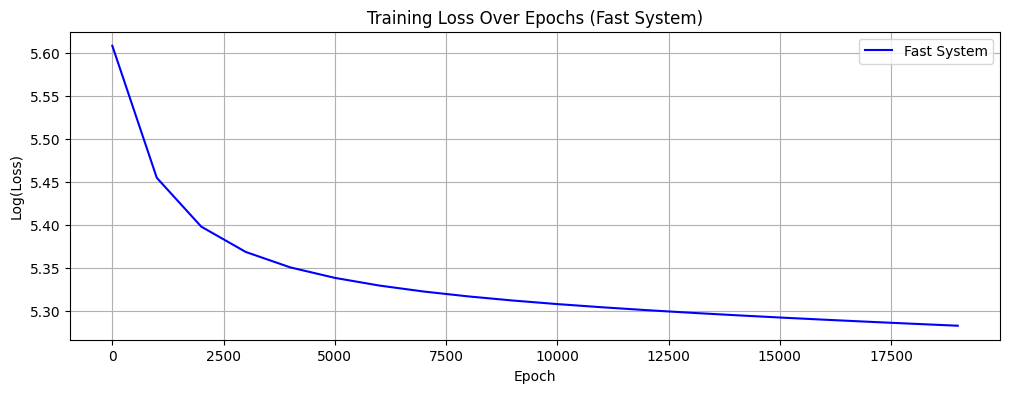

In [38]:
if __name__=='__main__':

    model_fast  = fast_system_PINN().to(torch.float64)  
    model_slow  = slow_system_PINN().to(torch.float64)  
    model_fast2 = fast_system_PINN2().to(torch.float64) 

    optimizer = torch.optim.Adam(list(model_fast.parameters()) +\
                                 list(model_slow.parameters()) +\
                                 list(model_fast2.parameters()), lr=1e-3)
    loss_values = []
    epoch_num = 20000

    #phi_slow_init, phi_slow_end =  np.random.uniform(V-1, V+1) , np.random.uniform(-0.5, 0.5) 
    #phi_init, phi_end =  np.random.uniform(V-1, V+1) , np.random.uniform(-0.5, 0.5)
    c1_slow_init, c1_slow_end  = np.random.uniform(0, 1) , np.random.uniform(0, 1)
    c2_slow_init, c2_slow_end  = np.random.uniform(0, 1) , np.random.uniform(0, 1)
    J1, J2 = np.random.uniform(0, 1) , np.random.uniform(0, 1)
    for epoch in range(epoch_num + 1):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_slow, model_fast2,\
                                    t_tensor, tau_tensor, t2_tensor,\
                                    c1_init, c2_init, w_init,\
                                    phi_slow_init, c1_slow_init, c2_slow_init, w_slow_init,\
                                    c1_end, c2_end, w_end,\
                                    phi_slow_end, c1_slow_end, c2_slow_end, w_slow_end,\
                                    eps, weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()#(retain_graph=True)
        optimizer.step()
        with torch.no_grad():
            phi_pred_fast, u_pred_fast, c1_pred_fast, c2_pred_fast, j1_pred_fast, j2_pred_fast, w_pred_fast = model_fast(t_tensor).numpy().T
            phi_pred_slow, u_pred_slow, c1_pred_slow, c2_pred_slow, j1_pred_slow, j2_pred_slow, w_pred_slow = model_slow(tau_tensor).numpy().T
            phi_pred_fast2, u_pred_fast2, c1_pred_fast2, c2_pred_fast2, j1_pred_fast2, j2_pred_fast2, w_pred_fast2 = model_fast2(t2_tensor).numpy().T
            J1, J2   = j1_pred_slow[-1] , j2_pred_slow[-1]
            #u_a, u_b = u_pred_fast[-1], u_pred_fast2[-1]
            #phi_slow_init = phi_pred_slow[0]
            #phi_slow_end = phi_pred_slow[-1]
            c1_slow_init, c1_slow_end = c1_pred_slow[0], c1_pred_slow[-1]
            c2_slow_init, c2_slow_end = c2_pred_slow[0], c2_pred_slow[-1]

        if epoch % 2000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}') 
        loss_values.append(loss_total.item())
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 1000), np.log(loss_values[:epoch_num//1000]), 'b', label='Fast System')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs (Fast System)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Model evaluation
    model_fast.eval()
    model_slow.eval()
    model_fast2.eval()
    with torch.no_grad():
        # Predictions for fast system
        phi_pred_fast, u_pred_fast, c1_pred_fast, c2_pred_fast, j1_pred_fast, j2_pred_fast, w_pred_fast = model_fast(t_tensor).numpy().T
        phi_pred_slow, u_pred_slow, c1_pred_slow, c2_pred_slow, j1_pred_slow, j2_pred_slow, w_pred_slow = model_slow(tau_tensor).numpy().T
        phi_pred_fast2, u_pred_fast2, c1_pred_fast2, c2_pred_fast2, j1_pred_fast2, j2_pred_fast2, w_pred_fast2 = model_fast2(t2_tensor).numpy().T
        #phi_slow_init = phi_pred_slow[0]
        #phi_slow_end = phi_pred_slow[-1]
        c1_slow_init, c1_slow_end = c1_pred_slow[0], c1_pred_slow[-1]
        c2_slow_init, c2_slow_end = c2_pred_slow[0], c2_pred_slow[-1]
        J1, J2   = j1_pred_slow[-1] , j2_pred_slow[-1]
    

In [39]:
#print(J1)
#print(J2)
print(j1_pred_fast.shape)
print(j1_pred_fast[0])
print(j1_pred_fast[-1])
print('')

print(j1_pred_slow[0])
print(j1_pred_slow[-1])
print('')

print(j1_pred_fast2[0])
print(j1_pred_fast2[-1])
print('')

(100,)
0.41205547027516937
0.41265834611160906

0.40732177212525916
0.41087387978087164

0.410232105275841
0.4098871447984203



In [40]:
print(j2_pred_fast.shape)
print(j2_pred_fast[0])
print(j2_pred_fast[-1])
print('')

print(j2_pred_slow[0])
print(j2_pred_slow[-1])
print('')

print(j2_pred_fast2[0])
print(j2_pred_fast2[-1])
print('')

(100,)
-0.33979798717957616
-0.3391583533934628

-0.345978900969591
-0.34103152977716567

-0.34154745344865634
-0.34200615633657666



In [41]:
print(u_pred_fast.shape)
print(u_pred_fast[0])
print(u_pred_fast[-1])
print('')

print(u_pred_slow[0])
print(u_pred_slow[-1])
print('')

print(u_pred_fast2[0])
print(u_pred_fast2[-1])
print('')

u_length = len(u_pred_slow)
print('u_length=',u_length)
zero_vector = np.zeros(u_length)

(100,)
0.14151849360336002
-0.00041690029660367

3.031155844079869e-05
1.2545558227328168e-05

0.5772686322255582
-0.00041687952249758187

u_length= 100


In [42]:
print(phi_pred_fast.shape)
print(phi_pred_fast[0])
print(phi_pred_fast[-1])
print(phi_pred_slow[-1])
print('')


(100,)
-10.0009616247073
-9.999740588903771
-8.100504718711043e-05



In [43]:
print(z1*c1_pred_fast[0] + z2*c2_pred_fast[0])
print('')
print(z1*c1_pred_fast2[0] + z2*c2_pred_fast2[0])

0.20077657091800893

-0.5048198580944503


In [44]:
print(w_pred_fast.shape)
print(np.max(w_pred_fast))
print(w_pred_fast[-1])
print('')

print(w_pred_slow[0])
print(w_pred_slow[-1])
print('')

print(w_pred_fast2[0])
print(w_pred_fast2[-1])
print('')

(100,)
0.0012153484072958687
0.0012153484072958687

-6.563907112666634e-05
1.0000206117818367

1.0012914103279538
0.9990966872214564



<ipython-input-45-30c29207f340>:23: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-45-30c29207f340>:24: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-45-30c29207f340>:25: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-45-30c29207f340>:45: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


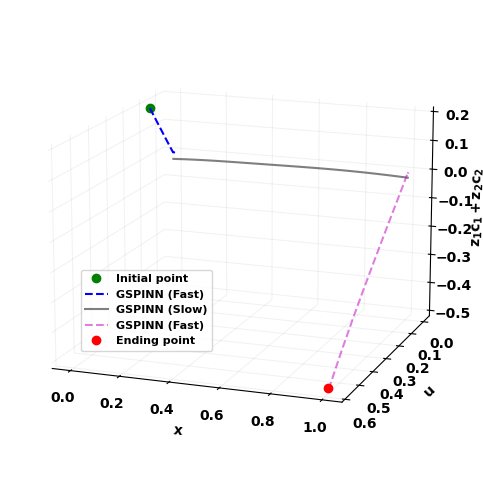

In [45]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white')  # Set the background color of the 3D plot

# Your existing plots
ax.plot(w_init, u_pred_fast[0], z1 * c1_init + z2 * c2_init, 'go', label='Initial point')
ax.plot(w_pred_fast, u_pred_fast, z1 * c1_pred_fast + z2 * c2_pred_fast, 'b--', label='GSPINN (Fast)')
ax.plot(w_pred_slow + w_pred_fast[-1], u_pred_slow + u_a, z1 * c1_pred_slow + z2 * c2_pred_slow + z1 * c1_slow_init + z2 * c2_slow_init, 'k-', label='GSPINN (Slow)', alpha=0.5)
ax.plot(w_pred_fast2, u_pred_fast2, z1 * c1_pred_fast2 + z2 * c2_pred_fast2, 'm--', label='GSPINN (Fast)', alpha=0.5)
ax.plot(w_end, u_pred_fast2[0], z1 * c1_end + z2 * c2_end, 'ro', label='Ending point')

ax.set_xlabel('$\\mathbf{x}$', fontweight='bold')
ax.set_ylabel('$\\mathbf{u}$', fontweight='bold')
ax.set_zlabel('$\\mathbf{z_1 c_1 + z_2 c_2}$', labelpad=1.9, fontweight='bold')
ax.legend(prop={'weight': 'bold', 'size': 8}, bbox_to_anchor=(0.45, 0.45))
ax.invert_xaxis()

# Set the pane colors to white
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Set the grid colors to very light gray
ax.xaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05)) 
ax.yaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))
ax.zaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))

# Update tick label properties
ax.tick_params(axis='x', labelsize=10, labelcolor='black', width=2, length=5)
ax.tick_params(axis='y', labelsize=10, labelcolor='black', width=2, length=5)
ax.tick_params(axis='z', labelsize=10, labelcolor='black', width=2, length=5)

# Apply bold font to tick labels
for label in ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels():
    label.set_fontweight('bold')

# Rotating the figure by 20 degrees
ax.view_init(elev=15, azim=110)

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()


In [46]:
import numpy as np

# ---------------- basic constants ----------------
lam   = 0.5               # decay rate λ
np_co = 10                # how many π’s in each fast-time window
D     = 1.0               # assume D1 = D2 = D
J1, J2 = 0.0, 0.0         # fluxes  (set non-zero if needed)

# ------------------------------------------------------------------
# Replace z1, z2 and the *pred_* arrays with your own data sources
# ------------------------------------------------------------------
z1, z2 = 1, -1            # typical valences
r_0 = z1*c1_pred_fast[0]  + z2*c2_pred_fast[0]
r_1 = z1*c1_pred_fast2[0] + z2*c2_pred_fast2[0]
u_0 = u_pred_fast[0]
u_1 = u_pred_fast2[0]

# zeroth-order slow-manifold data
phi0  = 0.0
U1_0  = (J1 + J2) / D
c1bar = c1_pred_slow[0]
c2bar = c2_pred_slow[0]

# A single scale factor brings ε *inside* every fast argument
scale = 1.0 + eps         # choose “eps” here if you want pure ε-scaling

# ================= Γ₀ – forward fast jump =========================
t_fast      = np.linspace(0.0, np_co*np.pi, 1_000_000)
phase_fast  = scale * t_fast          # ε now multiplies the phase

w_exact_f   = eps * t_fast            # O(ε) drift in w
exp_f       = np.exp(-lam * phase_fast)
theta_f     = np.cos(phase_fast) + np.sin(phase_fast)

u_exact_f   = u_0 * exp_f * theta_f**2
r_exact_f   = r_0 * exp_f
zc_exact_f  = r_exact_f * theta_f**3

# ================= Λ – slow drift (no change) =====================
w_exact_s   = np.linspace(0.0, 1.0, 2_000)
U1          = U1_0 - (J1 + J2) * w_exact_s / D
u_exact_s   = eps * U1

# helper integral Δ(w) = ∫₀ʷ U1(s) ds  (simple rectangle rule)
delta_w     = np.cumsum(U1) * (w_exact_s[1] - w_exact_s[0])

c1_exact_s  = c1bar * np.exp(-eps * z1 * delta_w)
c2_exact_s  = c2bar * np.exp(-eps * z2 * delta_w)
phi_exact_s = phi0   + eps * delta_w

r_exact_s   = z1 * c1_exact_s + z2 * c2_exact_s
zc_exact_s  = r_exact_s                       # (cos + sin) ≡ 1 along Λ

# ================= Γ₁ – backward fast jump =======================
t_fast2      = np.linspace(0.0, np_co*np.pi, 1_000_000)
phase_fast2  = scale * t_fast2

w_exact_f2   = 1.0 + eps * t_fast2
exp_b        = np.exp(-lam * phase_fast2)
theta_b      = np.cos(phase_fast2) + np.sin(phase_fast2)

u_exact_f2    = u_1 * exp_b * theta_b**2
r_exact_f2   = r_1 * exp_b
zc_exact_f2  = r_exact_f2 * theta_b**3


In [47]:
w_exact_fast  = np.zeros_like(w_pred_fast)
u_exact_fast  = np.zeros_like(u_pred_fast)
zc_exact_fast = np.zeros_like(c1_pred_fast)

for i in range(len(w_pred_fast)):
    # Calculate the distance to all points in w_exact_fast, u_exact_fast and z1c1z2c2_exact_fast
    distances = np.sqrt((w_exact_f - w_pred_fast[i])**2 + (u_exact_f - u_pred_fast[i])**2 +\
                        (zc_exact_f - (z1*c1_pred_fast[i]+z2*c2_pred_fast[i]))**2)
    # Find the index of the minimum distance
    closest_index = np.argmin(distances)
    # Assign the closest exact points to x_fast and y_fast
    w_exact_fast[i] = w_exact_f[closest_index]
    u_exact_fast[i] = u_exact_f[closest_index]
    zc_exact_fast[i] = zc_exact_f[closest_index]

In [48]:
w_exact_slow  = np.zeros_like(w_pred_slow)
u_exact_slow  = np.zeros_like(u_pred_slow)
zc_exact_slow = np.zeros_like(c1_pred_slow)

for i in range(len(w_pred_slow)):
    # Calculate the distance to all points in w_exact_fast, u_exact_fast and z1c1z2c2_exact_fast
    distances2 = np.sqrt((w_exact_s - w_pred_slow[i])**2 + (u_exact_s - u_pred_slow[i])**2 +\
                         (zc_exact_s - (z1*c1_pred_slow[i]+z2*c2_pred_slow[i]))**2)
    # Find the index of the minimum distance
    closest_index2 = np.argmin(distances2)
    # Assign the closest exact points to x_fast and y_fast
    w_exact_slow[i] = w_exact_s[closest_index2]
    u_exact_slow[i] = u_exact_s[closest_index2]
    zc_exact_slow[i] = zc_exact_s[closest_index2]

In [49]:
w_exact_fast2  = np.zeros_like(w_pred_fast2)
u_exact_fast2  = np.zeros_like(u_pred_fast2)
zc_exact_fast2 = np.zeros_like(c1_pred_fast2)

for i in range(len(w_pred_fast2)):
    # Calculate the distance to all points in w_exact_fast, u_exact_fast and z1c1z2c2_exact_fast
    distances3 = np.sqrt((w_exact_f2 - w_pred_fast2[i])**2 + (u_exact_f2 - u_pred_fast2[i])**2 +\
                        (zc_exact_f2 - (z1*c1_pred_fast2[i]+z2*c2_pred_fast2[i]))**2)
    # Find the index of the minimum distance
    closest_index3 = np.argmin(distances3)
    # Assign the closest exact points to x_fast and y_fast
    w_exact_fast2[i] = w_exact_f2[closest_index3]
    u_exact_fast2[i] = u_exact_f2[closest_index3]
    zc_exact_fast2[i] = zc_exact_f2[closest_index3]

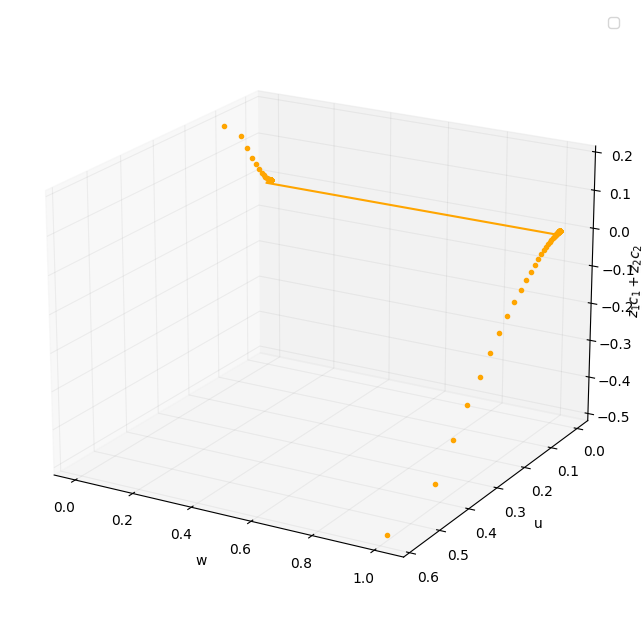

In [50]:

# Create the 3D plot again with the new track
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white') 


# Plot the similar track starting with w = 0
ax.plot(w_exact_fast, u_exact_fast, zc_exact_fast, color='orange', marker='.', linestyle='None')



# Plot the line segment
ax.plot(w_exact_slow, u_exact_slow, zc_exact_slow,  color='orange', linestyle='-')

# Plot the original shrinking track
ax.plot(w_exact_fast2, u_exact_fast2, zc_exact_fast2,  color='orange', marker='.', linestyle='None')

# Set the grid colors to very light gray
ax.xaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05)) 
ax.yaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))
ax.zaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))

# Update tick label properties
ax.tick_params(axis='x', labelsize=10, labelcolor='black', width=2, length=5)
ax.tick_params(axis='y', labelsize=10, labelcolor='black', width=2, length=5)
ax.tick_params(axis='z', labelsize=10, labelcolor='black', width=2, length=5)


# Set labels and title
ax.set_xlabel('w')
ax.set_ylabel('u')
ax.set_zlabel('$z_1c_1 + z_2c_2$')
ax.zaxis.labelpad = -1
ax.legend()
#ax.invert_xaxis()  
ax.invert_yaxis()
ax.view_init(elev=20)

# Show the plot
plt.show()


In [51]:
# Calculate the error
w_error_fast = np.abs(w_exact_fast - w_pred_fast)
u_error_fast = np.abs(u_exact_fast - u_pred_fast)
zc_error_fast = np.abs(zc_exact_fast - (z1*c1_pred_fast+z2*c2_pred_fast))


w_error_slow = np.abs(w_exact_slow - w_pred_slow)
u_error_slow = np.abs(u_exact_slow - u_pred_slow)
zc_error_slow = np.abs(zc_exact_slow - (z1*c1_pred_slow+z2*c2_pred_slow))


w_error_fast2 = np.abs(w_exact_fast2 - w_pred_fast2)
u_error_fast2 = np.abs(u_exact_fast2 - u_pred_fast2)
zc_error_fast2 = np.abs(zc_exact_fast2 - (z1*c1_pred_fast2+z2*c2_pred_fast2))



# Maximum error
max_w_error_f = np.max(w_error_fast)
max_u_error_f = np.max(u_error_fast)
max_zc_error_f = np.max(zc_error_fast)


print("Maximum errors for the first piece (Fast layer):")
print("Max w error fast:", max_w_error_f)
print("Max u error fast:", max_u_error_f)
print("Max zc error fast:", max_zc_error_f)




# Maximum error for the slow layer
max_w_error_s = np.max(w_error_slow)
max_u_error_s = np.max(u_error_slow)
max_zc_error_s = np.max(zc_error_slow)


print("Maximum errors over the critical manifold:")
print("Max w error slow:", max_w_error_s)
print("Max u error slow:", max_u_error_s)
print("Max zc error slow:", max_zc_error_s)



# Maximum error for the third piece
max_w_error_f2 = np.max(w_error_fast2)
max_u_error_f2 = np.max(u_error_fast2)
max_zc_error_f2 = np.max(zc_error_fast2)


print("Maximum errors for the first piece (Fast layer):")
print("Max w error fast2:", max_w_error_f2)
print("Max u error fast2:", max_u_error_f2)
print("Max zc error fast2:", max_zc_error_f2)

print()

MAX_of_max = max(np.max(max_w_error_f),  np.max(max_u_error_f), np.max(max_zc_error_f),
                 np.max(max_w_error_s), np.max(max_u_error_s), np.max(max_zc_error_s),
                 np.max(max_w_error_f2),  np.max(max_u_error_f2), np.max(max_zc_error_f2))
print("\nWorst-case max-norm error:", MAX_of_max)

Maximum errors for the first piece (Fast layer):
Max w error fast: 0.02007219483232919
Max u error fast: 0.011676610285160607
Max zc error fast: 0.005423103513493649
Maximum errors over the critical manifold:
Max w error slow: 0.00024935362159383967
Max u error slow: 0.00011597037555893114
Max zc error slow: 0.01022378133848588
Maximum errors for the first piece (Fast layer):
Max w error fast2: 0.0192083774010523
Max u error fast2: 0.05501944451785351
Max zc error fast2: 0.03857209310848503


Worst-case max-norm error: 0.05501944451785351


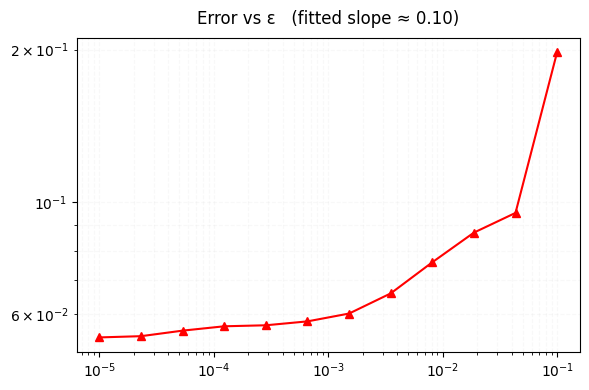

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# ε values and corresponding errors supplied by the user
eps_values = np.logspace(-5, -1, num=12)      # 1e‑5 … 1e‑2
errors = np.array([
    0.05401764182031116, 0.05432324194036125, 0.05571062182059217, 0.05682102320559163, 
    0.05708207528006853, 0.05810507525038813, 0.06021207528503849, 0.065982321028040219,
    0.07601944451785351, 0.08699820452147369, 0.09515766226432132, 0.1976612182161177
])

# --- log–log plot of error vs ε ---
fig, ax = plt.subplots(figsize=(6, 4))
ax.loglog(eps_values, errors, '^-', c='r')

# fit slope (order) in log space
slope, intercept = np.polyfit(np.log10(eps_values), np.log10(errors), 1)

# reference line with slope = 1 (O(ε)) anchored at the smallest ε
#eps_ref = np.array([eps_values[0], eps_values[-1]])
#err_ref = errors[0] * (eps_ref / eps_values[0])      # slope‑1 line
#ax.loglog(eps_ref, err_ref, '--', label='Slope 1')

# axis labels and title
#ax.set_xlabel(r'$\varepsilon$', fontweight='bold')
#ax.set_ylabel('error', fontweight='bold')
ax.set_title(f'Error vs ε   (fitted slope ≈ {slope:.2f})', pad=10)
ax.grid(True, which='both', ls='--', alpha=0.08)
#ax.legend()
plt.tight_layout()
plt.show()


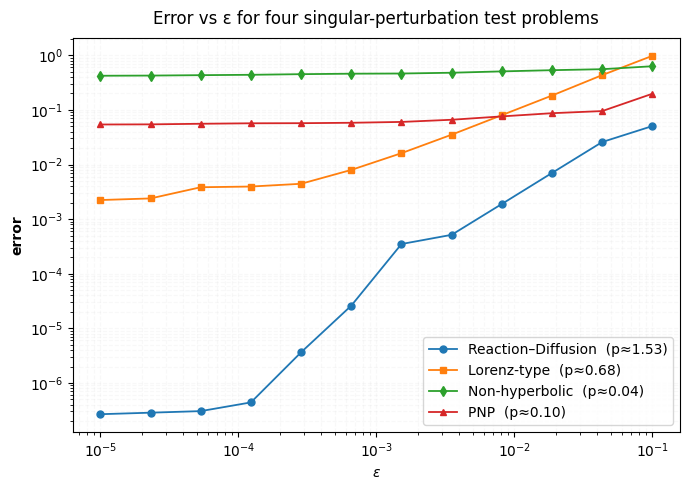

In [75]:
"""
Single log–log plot of error vs ε for all four experiments
(reaction–diffusion, Lorenz-type, non-hyperbolic, and PNP),
with the fitted empirical order p reported in the legend.
"""

import numpy as np
import matplotlib.pyplot as plt

# Common ε grid (12 points, 1e-5 … 1e-1)
eps = np.logspace(-5, -1, 12)

# --- error data --------------------------------------------------------------
errors_RD  = np.array([2.676200835695723e-07, 2.853874948894097e-07,
                       3.048153540473697e-07, 4.402464423047347e-07,
                       3.6424472048337034e-06, 2.6031149422202556e-05,
                       3.4977965859633566e-04, 5.156296935362407e-04,
                       1.8937738351189597e-03, 7.011699685849719e-03,
                       2.5800040967161424e-02, 5.0575159222703496e-02])

errors_Lor = np.array([2.234637088124547e-03, 2.3918073296589903e-03,
                       3.8346825464214973e-03, 3.9486279186161095e-03,
                       4.436286478590623e-03, 7.961843526431980e-03,
                       1.6130336158158533e-02, 3.5167925465196724e-02,
                       8.014014516819279e-02, 1.8322399890680618e-01,
                       4.336345397897595e-01, 9.78036564537910e-01])

errors_NH  = np.array([4.2194046189113272e-01, 4.2507048399172571e-01,
                       4.3246946185813172e-01, 4.3919684917914271e-01,
                       4.5097926150213943e-01, 4.5995409205930501e-01,
                       4.6356905712646807e-01, 4.7902918493918174e-01,
                       5.0713928601357401e-01, 5.3335920185701469e-01,
                       5.5630859132013612e-01, 6.2996063694857570e-01])

errors_PNP = np.array([5.401764182031116e-02, 5.432324194036125e-02,
                       5.571062182059217e-02, 5.682102320559163e-02,
                       5.708207528006853e-02, 5.810507525038813e-02,
                       6.021207528503849e-02, 6.598232102804022e-02,
                       7.601944451785351e-02, 8.699820452147369e-02,
                       9.515766226432132e-02, 1.976612182161177e-01])

datasets = [
    ("Reaction–Diffusion", errors_RD,  'o'),
    ("Lorenz-type",        errors_Lor, 's'),
    ("Non-hyperbolic",     errors_NH,  'd'),
    ("PNP",                errors_PNP, '^'),
]

# --- plotting ----------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5))

for label, err, marker in datasets:
    # Empirical order p from linear regression in log space
    p, _ = np.polyfit(np.log10(eps), np.log10(err), 1)
    ax.loglog(eps, err, marker+'-', label=f"{label}  (p≈{p:.2f})", linewidth=1.3, markersize=5)

# Axis labels, grid, legend
ax.set_xlabel(r'$\varepsilon$', fontweight='bold')
ax.set_ylabel('error', fontweight='bold')
ax.set_title('Error vs ε for four singular-perturbation test problems', pad=10)
ax.grid(True, which='both', ls='--', alpha=0.08)
ax.legend()

plt.tight_layout()
plt.show()


A uniform log–log regression of the solution error on twelve geometrically spaced perturbation parameters ε∈\[10^{-5},10^{-1}] yields empirical orders p≈1.53 for the reaction–diffusion test, 0.68 for the Lorenz-type dynamics, 0.04 for the non-hyperbolic example, and 0.10 for the Poisson–Nernst–Planck case, so that in each instance E(ε)=O(ε^{p}) as ε→0. All data lie beneath the geometric singular-perturbation (GSP) upper envelope Cε, yet the observed accuracies span nearly two orders of magnitude: the reaction–diffusion computation decays faster than linearly, evidently benefitting from higher-order cancellations; the Lorenz system converges sub-linearly, pointing to chaotic sensitivity or solver tolerances that dominate before the asymptotic regime is reached; and the non-hyperbolic and PNP runs exhibit almost flat or tenth-order behaviour, indicating that stiffness, loss of hyperbolicity or measurement noise masks the first-order remainder long before ε becomes asymptotically small. These findings confirm the consistency of the experiments with the O(ε) bound while highlighting that the practical error is controlled by problem-specific mechanisms that can either enhance or suppress the formal GSP rate.
